In [1]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.gridspec as gridspec
from sklearn.linear_model import RidgeCV, LinearRegression
from scipy.interpolate import LinearNDInterpolator
from scipy.stats import sem, pearsonr
from my_utils import *

from pathlib import Path
import sys

In [2]:
modelpath = Path('../model')
sys.path.append(str(modelpath))
import config.config as config

arg = config.ConfigGain()
arg.device = 'cpu'
arg.process_gain_range = [2, 2]

In [3]:
# agents checkpoints path
progress_agents_path = Path('../data/agents')
# agents checkpoints performance path
training_curve_path = Path('../data/training_curve')
# figure path
figure_path = Path('../paper_figures/figure5')

# Select agent checkpoints for analyses

In [4]:
def select_agents(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain'):
    perform_files = [[pd.read_csv(file)[(pd.read_csv(file).episode > 0) & (pd.read_csv(file).episode < MAX_TRAINING_T)] 
                      for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
                     for agent_arch in agent_archs]
    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    best_seeds = [seed[np.argmax([np.sum([file[file.task == task].reward_rate 
                                          for task in file.task.unique()], axis=0).max()
                                  for file in perform_file])] 
                  for perform_file, seed in zip(perform_files, seeds)]
    best_files_idx = [np.argmax([np.sum([file[file.task == task].reward_rate 
                                         for task in file.task.unique()], axis=0).max()
                                 for file in perform_file]) 
                      for perform_file in perform_files]
    
    best_paths = [progress_agents_path / agent_arch / task / f'seed{seed}'
                  for agent_arch, seed in zip(agent_archs, best_seeds)]
    
    best_files = [perform_file[file_idx] for perform_file, file_idx in zip(perform_files, best_files_idx)]
    best_episodes = [file.episode.unique()[np.sum([file[file.task == task].reward_rate 
                                                   for task in file.task.unique()], axis=0).argmax()] 
                     for file in best_files]

    best_agents = [list(best_path.glob(f'*-{best_episode}.*'))[0].stem.split('.')[0]
                   for best_path, best_episode in zip(best_paths, best_episodes)]
    
    return best_seeds, best_paths, best_agents, perform_files

In [5]:
Models = {'Holistic_Actor': 'Actor1', 'Holistic_Critic': 'Critic1',
          'Modular_Actor': 'Actor3', 'Modular_Critic': 'Critic5'}
for k, v in Models.items():
    exec(f'from {v} import {v[:-1]} as {k}')

agent_archs = [Models['Holistic_Actor'] + Models['Holistic_Critic'], 
               Models['Modular_Actor'] + Models['Holistic_Critic'],
               Models['Holistic_Actor'] + Models['Modular_Critic'],
               Models['Modular_Actor'] + Models['Modular_Critic']]

MAX_TRAINING_T = 1e4

In [6]:
best_seeds, best_paths, best_agents, perform_files = select_agents(progress_agents_path, 
                                                                   agent_archs, 
                                                                   MAX_TRAINING_T=MAX_TRAINING_T)

In [7]:
def select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain'):    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    
    agent_paths = []; agent_files = []
    for agent_arch, seeds_ in zip(agent_archs, seeds): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / task / f'{agent_arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                      for task in perform_file.task.unique()], axis=0).argmax()]
            
            agent_path.append(progress_agents_path / agent_arch / task / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    
    return agent_paths, agent_files

In [8]:
agent_paths, agent_files = select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain')

# Run agents

In [9]:
from Agent_RNN import *
from Environment import Env

In [10]:
def RNN_agent_simulation(agent, target_positions, gains):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []; pos_theta = []; pos_r_end = []; pos_theta_end = []
    pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []

    for target_position, gain in zip(target_positions, gains):
        cross_start_threshold = False
        x = env.reset(target_position=target_position, pro_gains=gain)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)

            true_states.append(x)
            states.append(state)
            actions.append(action)
            
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

            if is_stop and cross_start_threshold:
                break

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))
        
        state_.append(torch.cat(states))

        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions).squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())
        
        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))

    agent.bstep.obs_noise_range = config.ConfigGain().obs_noise_range
    
    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps, gain_v=torch.stack(gains)[:, 0].numpy(),
                                 gain_w=torch.stack(gains)[:, 1].numpy(), 
                                 state=state_, action=action_))

In [11]:
models_ = dict([(v, k) for k, v in Models.items()])
agents = []
for idx, agent_arch in enumerate(agent_archs):
    filename = best_agents[idx]
    agent = Agent(arg, eval(models_[agent_arch[:6]]), eval(models_[agent_arch[6:]]))
    agent.data_path = best_paths[idx]
    agent.load(filename, load_memory=False, load_optimzer=False)
    agents.append(agent)

In [12]:
SAMPLE_SIZE_L = 5000
SAMPLE_SIZE_S = 2000

In [13]:
reset_seeds(0)
env = Env(arg)
target_positions = []
gains_rand = []

for _ in range(SAMPLE_SIZE_L):
    __ = env.reset()
    target_positions.append(env.target_position)
    gains_rand.append(env.pro_gains)

In [14]:
agent_trajectories = []
for agent in agents:
    traj = []
    for gain in [1, 1.5, 2] + [gains_rand]:
        if not isinstance(gain, list):
            target_positions_ = target_positions[:SAMPLE_SIZE_S]
            gains = [gain * arg.process_gain_default] * SAMPLE_SIZE_S
        else:
            target_positions_ = target_positions
            gains = gains_rand
        traj.append(RNN_agent_simulation(agent, target_positions_, gains))
    agent_trajectories.append(traj)

In [15]:
agents_all = []
for idx, agent_arch in enumerate(agent_archs):
    agents_ = []
    for agent_path, agent_file in zip(agent_paths[idx], agent_files[idx]):
        agent = Agent(arg, eval(models_[agent_arch[:6]]), eval(models_[agent_arch[6:]]))
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
    agents_all.append(agents_)

In [16]:
agent_trajectories_all = []
for agents_ in agents_all:
    traj = []
    for gain in [1, 1.5, 2] + [gains_rand]:
        if not isinstance(gain, list):
            target_positions_ = target_positions[:SAMPLE_SIZE_S]
            gains = [gain * arg.process_gain_default] * SAMPLE_SIZE_S
        else:
            target_positions_ = target_positions
            gains = gains_rand
        
        traj.append([RNN_agent_simulation(agent, target_positions_, gains) for agent in agents_])
    agent_trajectories_all.append(traj)    

# Figures

In [17]:
locals().update(config_colors())
major_formatter = FuncFormatter(my_tickformatter)

fontsize = 7
lw = 1

## 5a

In [18]:
def get_neural_response(agent, df):
    responses = []
    with torch.no_grad():
        for _, trial in df.iterrows():
            response = agent.actor.rnn(trial.state)[0]
            responses.append(response.squeeze(1))
        df['response'] = responses
    return torch.cat(responses).numpy()

In [19]:
xrange = np.array([-400, 400]); yrange = np.array([0, 600]); num_bins_x = 80; num_bins_y = 60
kernel_size = 5
xx, yy = [i.T for i in np.mgrid[xrange[0]:xrange[-1]:eval(f'{num_bins_x + 1}j'), 
                                yrange[0]:yrange[-1]:eval(f'{num_bins_y + 1}j')]]
x_bw = abs(xrange).sum() / num_bins_x; y_bw = abs(yrange).sum() / num_bins_y

agent_zzs = []
for agent, trajectories in zip([agents_all[0][1], agents[-1]], [agent_trajectories_all[0], agent_trajectories[-1]]):
    zzs = []
    for df in trajectories[:-1]:
        df = df[1] if isinstance(df, list) else df
        x = np.hstack(df.pos_x)
        y = np.hstack(df.pos_y)
        z = get_neural_response(agent, df)
        
        zzs_ = []
        for idx in range(z.shape[1]):
            interp = LinearNDInterpolator((x, y), z[:, idx])
            zz = interp(xx[:-1, :-1] + 0.5 * x_bw, yy[:-1, :-1] + 0.5 * y_bw)
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                zz = convolve(zz, np.ones((kernel_size, kernel_size)), boundary='extend')
            zzs_.append(zz)
        zzs.append(zzs_)
    agent_zzs.append(zzs)

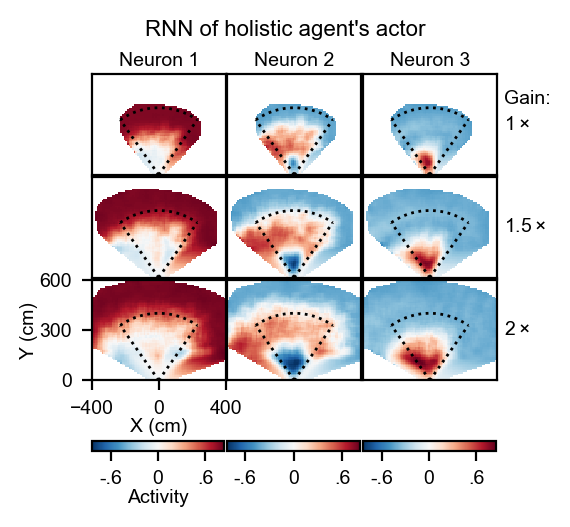

In [31]:
xticks = np.linspace(*xrange, 3)
yticks = np.linspace(*yrange, 3)
width = 3
height = 2.5
title_pad = 3

xdata = xx; ydata = yy; zdata = agent_zzs[0]
neuron_indices = [73, 53, 59]
task_names =  [fr'${i}\times$' for i in [1, 1.5, 2]]

auxi_lines = draw_arena()

with initiate_plot(width, height, 200) as fig:
    for idx, f_idx in enumerate(range(1, len(zdata) * len(neuron_indices) + 1)):
        fig.suptitle("RNN of holistic agent's actor", fontsize=fontsize + 1, y=0.99, x=0.54)
        ax = fig.add_subplot(len(zdata), len(neuron_indices), f_idx)
        ax.set_aspect('equal')
        if f_idx <= 3:
            ax.set_title(f'Neuron {f_idx}', fontsize=fontsize, pad=title_pad) 
        plt.xticks([], fontsize=fontsize)
        plt.yticks([], fontsize=fontsize)
        ax.set_xlabel('', fontsize=fontsize)
        ax.set_ylabel('', fontsize=fontsize)
        ax.set_xlim(xticks[0], xticks[-1])
        ax.set_ylim(yticks[0], yticks[-1])
        
        [ax.plot(*line, ls=':', lw=lw, c='k') for line in auxi_lines]
        
        zdata_ = zdata[idx // 3][neuron_indices[idx % 3]]
        ztemp = np.hstack([zdata[i][neuron_indices[idx % 3]].flatten() for i in range(len(zdata))])
        ztemp = abs(ztemp[~np.isnan(ztemp)])
        cmeshplot = ax.pcolormesh(xdata, ydata, zdata_, cmap='RdBu_r', 
                                  norm=TwoSlopeNorm(vmin=-ztemp.max(), vmax=ztemp.max(), vcenter=0))
        cb = fig.colorbar(cmeshplot)
        cb.remove()
        
        if idx % 3 == 2:
            ax.text(440, 450, 'Gain:', fontsize=fontsize, va='center') if idx == 2 else None
            ax.text(440, 300, task_names[idx // 3], fontsize=fontsize, va='center')
        
        if f_idx >= 7:
            cbaxes = ax.inset_axes([0, -0.7, 0.99, 0.1]) 
            cbar = fig.colorbar(cmeshplot, cax=cbaxes, orientation='horizontal')
            cbar.ax.tick_params(labelsize=fontsize)
            cbar_ticks = [-0.6, 0, 0.6]
            cbar_ticklabels = ['-.6', 0, '.6']
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticklabels)
            cbar.set_label('Activity', fontsize=fontsize) if f_idx == 7 else None
            cbar.ax.xaxis.set_label_coords(0.5, -3.8)
        
        if f_idx == 7:
            plt.xticks(xticks, fontsize=fontsize)
            plt.yticks(yticks, fontsize=fontsize)
            ax.set_xlabel('X (cm)', fontsize=fontsize)
            ax.set_ylabel('Y (cm)', fontsize=fontsize)
            ax.xaxis.set_label_coords(0.5, -0.37)
            ax.yaxis.set_label_coords(-0.4, 0.5)
        
    fig.tight_layout(pad=0.4, h_pad=-0.14, w_pad=-2.55, rect=(0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='spatial_tuning2'), orientation='portrait', format='pdf', transparent=True)

## 5b

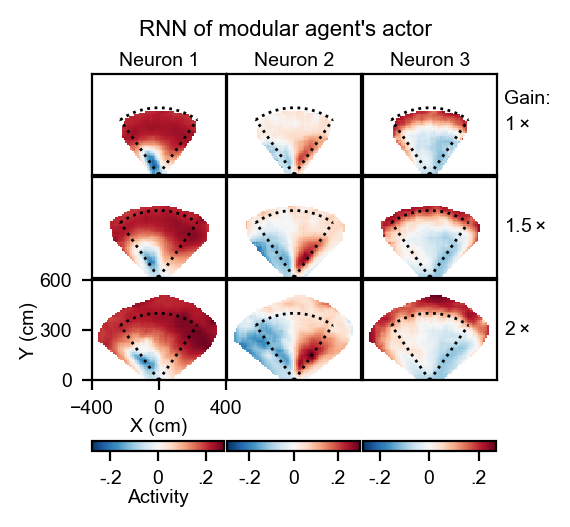

In [32]:
xticks = np.linspace(*xrange, 3)
yticks = np.linspace(*yrange, 3)
width = 3
height = 2.5
title_pad = 3

xdata = xx; ydata = yy; zdata = agent_zzs[-1]
neuron_indices = [13, 30, 73]
task_names =  [fr'${i}\times$' for i in [1, 1.5, 2]]

auxi_lines = draw_arena()

with initiate_plot(width, height, 200) as fig:
    for idx, f_idx in enumerate(range(1, len(zdata) * len(neuron_indices) + 1)):
        fig.suptitle("RNN of modular agent's actor", fontsize=fontsize + 1, y=0.99, x=0.54)
        ax = fig.add_subplot(len(zdata), len(neuron_indices), f_idx)
        ax.set_aspect('equal')
        if f_idx <= 3:
            ax.set_title(f'Neuron {f_idx}', fontsize=fontsize, pad=title_pad) 
        plt.xticks([], fontsize=fontsize)
        plt.yticks([], fontsize=fontsize)
        ax.set_xlabel('', fontsize=fontsize)
        ax.set_ylabel('', fontsize=fontsize)
        ax.set_xlim(xticks[0], xticks[-1])
        ax.set_ylim(yticks[0], yticks[-1])
        
        [ax.plot(*line, ls=':', lw=lw, c='k') for line in auxi_lines]
        
        zdata_ = zdata[idx // 3][neuron_indices[idx % 3]]
        ztemp = np.hstack([zdata[i][neuron_indices[idx % 3]].flatten() for i in range(len(zdata))])
        ztemp = abs(ztemp[~np.isnan(ztemp)])
        cmeshplot = ax.pcolormesh(xdata, ydata, zdata_, cmap='RdBu_r', 
                                  norm=TwoSlopeNorm(vmin=-ztemp.max(), vmax=ztemp.max(), vcenter=0))
        cb = fig.colorbar(cmeshplot)
        cb.remove()
        
        if idx % 3 == 2:
            ax.text(440, 450, 'Gain:', fontsize=fontsize, va='center') if idx == 2 else None
            ax.text(440, 300, task_names[idx // 3], fontsize=fontsize, va='center')
        
        if f_idx >= 7:
            cbaxes = ax.inset_axes([0, -0.7, 0.99, 0.1]) 
            cbar = fig.colorbar(cmeshplot, cax=cbaxes, orientation='horizontal')
            cbar.ax.tick_params(labelsize=fontsize)
            cbar_ticks = [-0.2, 0, 0.2]
            cbar_ticklabels = ['-.2', 0, '.2']
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticklabels)
            cbar.set_label('Activity', fontsize=fontsize) if f_idx == 7 else None
            cbar.ax.xaxis.set_label_coords(0.5, -3.8)
        
        if f_idx == 7:
            plt.xticks(xticks, fontsize=fontsize)
            plt.yticks(yticks, fontsize=fontsize)
            ax.set_xlabel('X (cm)', fontsize=fontsize)
            ax.set_ylabel('Y (cm)', fontsize=fontsize)
            ax.xaxis.set_label_coords(0.5, -0.37)
            ax.yaxis.set_label_coords(-0.4, 0.5)
        
    fig.tight_layout(pad=0.4, h_pad=-0.14, w_pad=-2.55, rect=(0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='spatial_tuning'), orientation='portrait', format='pdf', transparent=True)

## 5c

In [20]:
_ = [[get_neural_response(agent, df) for df in dfs] for agent, dfs in zip(agents, agent_trajectories)]

In [21]:
train_frac = 0.7
def fit_decoder(trajectory, start_idx=0, variables=['pos_x', 'pos_y']):
    key = 'response'
    train_trajectory = trajectory[:round(len(trajectory) * train_frac)]
    train_X = np.vstack([x[start_idx:] for _, x in train_trajectory[key].iteritems()])
    test_trajectory = trajectory[round(len(trajectory) * train_frac):]
    test_X = np.vstack([x[start_idx:] for _, x in test_trajectory[key].iteritems()])
    
    y = train_trajectory[variables].values
    train_y = np.vstack([np.hstack([v[start_idx:] for v in y[:, i]]) for i in range(y.shape[1])]).T
    y = test_trajectory[variables].values
    test_y = np.vstack([np.hstack([v[start_idx:] for v in y[:, i]]) for i in range(y.shape[1])]).T
    
    decoder = RidgeCV()
    decoder.fit(train_X, train_y)
    
    return decoder, test_X, test_y

In [22]:
decoders = [list(map(fit_decoder, trajectories)) for trajectories in agent_trajectories]

In [23]:
trial_idx = 8

data_x = []; data_y = []
for decoders_, trajectories in zip([decoders[0], decoders[3]], [agent_trajectories[0], agent_trajectories[3]]):
    data_x_ = []; data_y_ = []
    for (idx, decoder), trajectory in zip(enumerate(decoders_), trajectories):
        trial = trajectory.iloc[int(len(trajectory) * train_frac) + trial_idx]
        if idx == 0:
            data_target = (trial[['target_x', 'target_y']].values.astype(float))
        data_x_.append(np.vstack(trial[['pos_x', 'pos_y']]))
        data_y_.append(decoder[0].predict(trial.response).T)
    data_x.append(data_x_)
    data_y.append(data_y_)

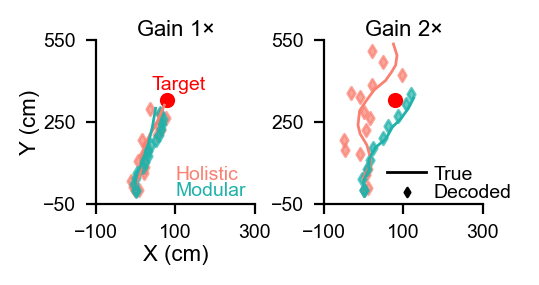

In [33]:
width = 2.5; height = 1.3
title_pad = 1

xmins, xmaxs = [-100, -100], [300, 300]
xticks = [np.linspace(xmin, xmax, 3) for xmin, xmax in zip(xmins, xmaxs)]
ymins, ymaxs = [-50, -50], [550, 550]
yticks = [np.linspace(ymin, ymax, 3) for ymin, ymax in zip(ymins, ymaxs)]

titles = [fr'Gain {i}$\times$' for i in [1, 2]]
gain_indices = [0, 2]

with initiate_plot(width, height, 200) as fig:
    for f_idx in range(2):
        ax = fig.add_subplot(1, 2, f_idx + 1)
        ax.set_title(titles[f_idx], fontsize=fontsize + 1, fontweight='normal', pad=title_pad)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.xticks(xticks[f_idx], fontsize=fontsize)
        plt.yticks(yticks[f_idx], fontsize=fontsize)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim([xmins[f_idx], xmaxs[f_idx]])
        ax.set_ylim([ymins[f_idx], ymaxs[f_idx]])
        
        for (idx, x), y, c in zip(enumerate(data_x), data_y, [holistic_c, modular_c]):
            ax.plot(*x[gain_indices[f_idx]], c=c, lw=lw)
            ax.scatter(*y[gain_indices[f_idx]], c=c, lw=lw, s=10, marker='d', alpha=0.7)
            
        ax.scatter(*data_target, c='r', lw=lw, s=20)
        
        if f_idx == 0:
            ax.set_xlabel(r'X (cm)', fontsize=fontsize + 1)
            ax.set_ylabel(r'Y (cm)', fontsize=fontsize + 1)
            ax.xaxis.set_label_coords(0.5, -0.25)
            ax.yaxis.set_label_coords(-0.35, 0.5)

        if f_idx == 1:
            l1 = ax.plot([], [], c='k', lw=lw, label='True')
            s1 = ax.scatter([], [], c='k', lw=lw, s=5, marker='d', label='Decoded')
            ax.legend(fontsize=fontsize, frameon=False, loc=[0.35, -0.03], 
                      handletextpad=0.4, labelspacing=0, ncol=1, columnspacing=0.8)
        elif f_idx == 0:
            ax.text(100, -20, s='Modular', fontsize=fontsize, c=modular_c)
            ax.text(100, 40, s='Holistic', fontsize=fontsize, c=holistic_c)
            ax.text(data_target[0] - 40, data_target[1] + 40, s='Target', fontsize=fontsize, c='r')
    
    fig.tight_layout(pad=0.1, w_pad=0, h_pad=0.2, rect=(0, -0.02, 1, 0.98))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='trial_example'), orientation='portrait', format='pdf', transparent=True)

## 5d

In [24]:
_ = [[[get_neural_response(agent, df) for agent, df in zip(agents_, dfs)] for dfs in dfs_] 
     for agents_, dfs_ in zip(agents_all, agent_trajectories_all)]

In [25]:
start_idx = 0
decoders_all = [[list(map(fit_decoder, traj, [start_idx] * len(traj))) 
                 for traj in trajectories] for trajectories in agent_trajectories_all]

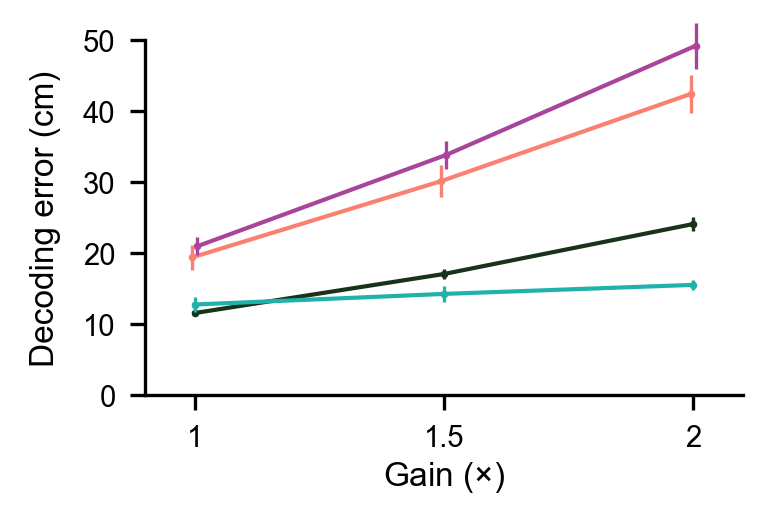

In [34]:
width = 2.4; height = 1.6
marker = '.'; marker_size = 5; marker_lw = lw * 0.7

xticks = np.arange(1, 4)
xticklabels = [1, 1.5, 2]
yticks = np.linspace(0, 50, 6)

colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
labels = ['Holistic', 'Modular actor+Holistic critic', 'Holistic actor+Modular critic', 'Modular']
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Gain ($\times$)', fontsize=fontsize + 1)
    ax.set_ylabel('Decoding error (cm)', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0] - 0.2, xticks[-1] + 0.2)
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.18)
    ax.yaxis.set_label_coords(-0.14, 0.5)
    #ax.xaxis.set_major_formatter(major_formatter)
    ax.yaxis.set_major_formatter(major_formatter)
    
    xshifts = [-0.01, 0.01, 0, 0]        
    for agent_idx, decoders_ in enumerate(decoders_all):
        xdata = xticks + xshifts[agent_idx]
        ymean = [np.mean([np.linalg.norm(deco[0].predict(deco[1])[:, :2] - deco[2][:, :2], axis=1).mean() 
                          for deco in decoders])
                 for decoders in decoders_[:-1]]
        yerror = [sem([np.linalg.norm(deco[0].predict(deco[1])[:, :2] - deco[2][:, :2], axis=1).mean() 
                       for deco in decoders])
                  for decoders in decoders_[:-1]]
        
        ax.scatter(xdata, ymean, c=colors[agent_idx], s=marker_size, lw=marker_lw, marker=marker)
        ax.plot(xdata, ymean, c=colors[agent_idx], lw=lw, label=labels[agent_idx])
        ax.errorbar(xdata, ymean, yerror, c=colors[agent_idx], lw=lw * 0.8, ls='none', clip_on=False) 
        
    fig.tight_layout(pad=0.15, rect=(0, 0, 1, 1))

    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='position_error'), orientation='portrait', format='pdf', transparent=True)

## S5a

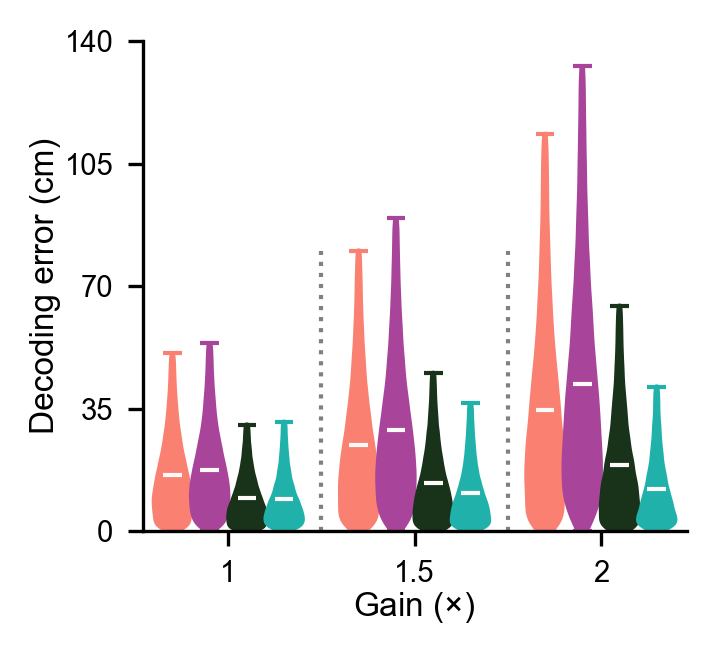

In [35]:
width = 2.2
height = 2
violin_width = 0.2

xticklabels = [1, 1.5, 2]
xticks = np.arange(len(xticklabels))
yticks = np.linspace(0, 140, 5)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Gain ($\times$)', fontsize=fontsize + 1)
    ax.set_ylabel('Decoding error (cm)', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0] - 2.3 * violin_width, xticks[-1] + 2.3 * violin_width]); 
    ax.set_ylim([yticks[0], yticks[-1]])
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.12)
    ax.yaxis.set_major_formatter(major_formatter)
    
    positions = [xticks + i * violin_width for i in (np.arange(-2, 2) + 0.5)]
    
    colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
    for (idx, decoders_), position, color in zip(enumerate(decoders_all), positions, colors):
        data = [np.hstack([np.linalg.norm(deco[0].predict(deco[1])[:, :2] - deco[2][:, :2], axis=1) 
                           for deco in decoders]) 
                for decoders in decoders_[:-1]]
        locals()[f'vp{idx}'] = ax.violinplot(filter_fliers(data), positions=position, 
                                             widths=violin_width, showmeans=True)
        set_violin_plot(locals()[f'vp{idx}'], facecolor=color, edgecolor=color)
        
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    
    [ax.plot(np.linspace(x, x), np.linspace(0, y), c='gray', ls=':', lw=lw) 
     for x, y in zip(xticks[:-1] + 0.5, [80, 80, yticks[-1]])]
    
    plt.tight_layout(pad=0.1, rect=(0.01, 0, 1.01, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='sup_position_error'), orientation='portrait', format='pdf', transparent=True)

## 5e

In [26]:
dfs_roc = [agent_trajectories_all[agent_idx][-1] for agent_idx in range(len(agent_trajectories_all))]

In [27]:
max_reward_boundary = int(max([df.relative_radius_end.max() for dfs in dfs_roc for df in dfs])) + 1
hypo_reward_boundaries = np.arange(max_reward_boundary)

targets = dfs_roc[0][0][['target_x', 'target_y']].values[round(train_frac * len(dfs_roc[0][0])):]
shuffled_targets = targets.copy()
rng = default_rng(1); rng.shuffle(shuffled_targets, axis=0)

ydata_subjects = []; xdata_subjects = []
for dfs in dfs_roc:
    ydata_seeds = []; xdata_seeds = []
    for df in dfs:
        ydata = []; xdata = []
        df = df[round(train_frac * len(dfs_roc[0][0])):]
        for reward_boundary in hypo_reward_boundaries:
            ydata.append((np.linalg.norm(np.vstack([[i[-1] for i in df.pos_x], [i[-1] for i in df.pos_y]]).T 
                                         - targets, axis=1) 
                          < reward_boundary).sum() / len(df))
            xdata.append((np.linalg.norm(np.vstack([[i[-1] for i in df.pos_x], [i[-1] for i in df.pos_y]]).T
                                         - shuffled_targets, axis=1) 
                          < reward_boundary).sum() / len(df))
        ydata_seeds.append(ydata); xdata_seeds.append(xdata)
    ydata_subjects.append(ydata_seeds); xdata_subjects.append(xdata_seeds)

In [28]:
auc_data = [[np.trapz(ydata_subjects[agent_idx][idx], xdata_subjects[agent_idx][idx]) for idx in range(8)] 
            for agent_idx in range(len(dfs_roc))]

In [29]:
decoders_roc = [decoders_all[agent_idx][-1] for agent_idx in range(len(decoders_all))]
decoders_error_data = [[np.linalg.norm((decoders_roc[agent_idx][idx][0].predict(decoders_roc[agent_idx][idx][1])
                                        - decoders_roc[agent_idx][idx][2])[:, :2], axis=1).mean()
                        for idx in range(8)] for agent_idx in range(len(decoders_roc))]

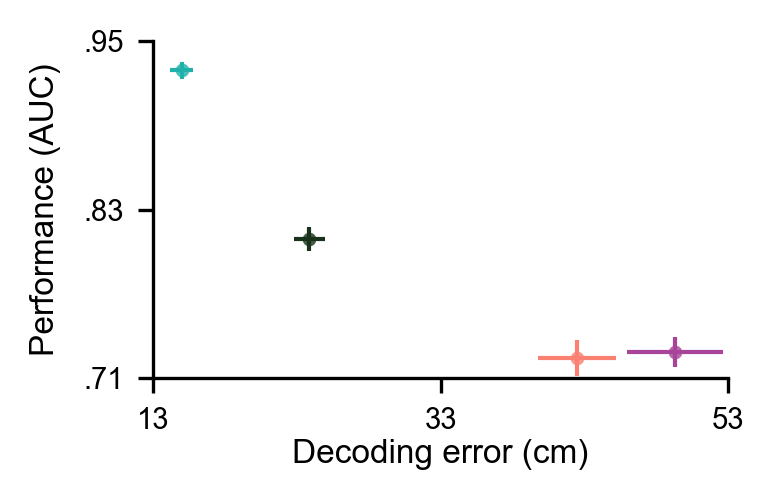

In [36]:
width = 2.4; height = 1.5
marker = 'o'; marker_size = 10; marker_lw = 0.1

yticks = [0.71, 0.83, 0.95]
xticks = np.linspace(13, 53, 3)

colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_ylabel('Performance (AUC)', fontsize=fontsize + 1)
    ax.set_xlabel('Decoding error (cm)', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.18)
    ax.yaxis.set_label_coords(-0.16, 0.5)
    ax.xaxis.set_major_formatter(major_formatter)
    ax.yaxis.set_major_formatter(major_formatter)
          
    for (agent_idx, xdata), ydata in zip(enumerate(decoders_error_data), auc_data):
        xmean = np.mean(xdata); xerr = sem(xdata)
        ymean = np.mean(ydata); yerr = sem(ydata)
        
        ax.scatter(xmean, ymean, c=colors[agent_idx], s=marker_size, lw=marker_lw, marker=marker, alpha=0.8)
        ax.errorbar(xmean, ymean, yerr=yerr, xerr=xerr, c=colors[agent_idx], lw=lw, ls='none') 
        
    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='auc_vs_error'), orientation='portrait', format='pdf', transparent=True)

## S5b

PearsonRResult(statistic=0.501135852909067, pvalue=0.0)
1.2826626010099127
PearsonRResult(statistic=0.45220488865584796, pvalue=0.0)
1.236485419839634
PearsonRResult(statistic=0.6138168062185942, pvalue=0.0)
1.314894152515204
PearsonRResult(statistic=0.6367698808958998, pvalue=0.0)
1.0835609011759344


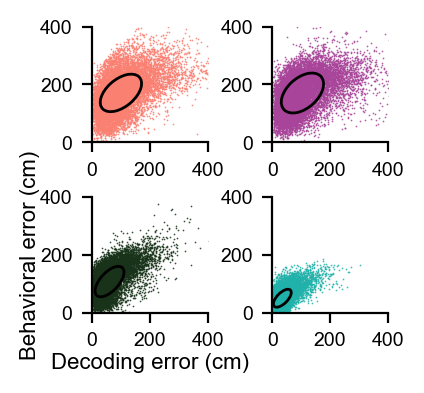

In [37]:
width = 2; height = 2
title_pad = 1.5
scatter_lw = 0.3; scatter_s = 0.5


xmax = 400; ymax = 400
xticks = np.linspace(0, xmax, 3)
yticks = np.linspace(0, ymax, 3)

titles = ['Holistic', 'Modular actor+\nHolistic critic', 'Holistic actor+\nModular critic', 'Modular']
colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
title_ys = [1.1, 1, 1, 1.1]

gain_idx = 3
start_idx = int(train_frac * len(agent_trajectories[0][gain_idx]))

with initiate_plot(width, height, 200) as fig:
    for f_idx in range(4):
        ax = fig.add_subplot(2, 2, f_idx + 1)
        ax.set_aspect('equal')
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.xticks(xticks, fontsize=fontsize)
        plt.yticks(yticks, fontsize=fontsize)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim([0, xmax])
        ax.set_ylim([0, ymax])
        
        decoding_errors = []; behavior_errors = []
        for seed_idx in range(8):
            df = agent_trajectories_all[f_idx][gain_idx][seed_idx].iloc[start_idx:]
            response = torch.stack([r[-1] for r in df.response])
            decoder = decoders_all[f_idx][gain_idx][seed_idx][0]
            predicted_position = decoder.predict(response)[:, :2]
            true_position = df[['pos_x_end', 'pos_y_end']].values
            decoding_error = np.linalg.norm(predicted_position - true_position, axis=1)
            behavior_error = df.relative_radius_end.values
            decoding_errors.append(decoding_error); behavior_errors.append(behavior_error)
        decoding_errors, behavior_errors = map(np.hstack, [decoding_errors, behavior_errors])
        
        ax.scatter(decoding_errors, behavior_errors, c=colors[f_idx], lw=scatter_lw, s=scatter_s, 
                   marker='.', alpha=0.7)
        confidence_ellipse(decoding_errors, behavior_errors, ax, n_std=1, ec='k', lw=lw)
        print(pearsonr(decoding_errors, behavior_errors))
        print(get_scatter_slope(decoding_errors, behavior_errors))
        
        if f_idx == 2:
            ax.set_ylabel(r'Behavioral error (cm)', fontsize=fontsize + 1)
            ax.set_xlabel(r'Decoding error (cm)', fontsize=fontsize + 1)
            ax.xaxis.set_label_coords(0.5, -0.35)
            ax.yaxis.set_label_coords(-0.45, 0.5)
    
    fig.tight_layout(pad=0.1, w_pad=-0.1, h_pad=-0.8, rect=(-0.0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.png'.format(
    #    name='sup_correlation'), orientation='portrait', format='png', transparent=True, dpi=2000)